# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score


# Load Data

In [2]:
bank_df = pd.read_csv('bank.csv', delimiter=';')

file_path = 'adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
adult_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)

# Binary indicators for capital gains and losses
adult_df['positive_capital_gain'] = (adult_df['capital-gain'] > 0).astype(int)
adult_df['positive_capital_loss'] = (adult_df['capital-loss'] > 0).astype(int)

# Interaction feature between age and education-num
adult_df['age_education_interaction'] = adult_df['age'] * adult_df['education-num']

# Aggregating less common categories into 'Other'
top_occupations = adult_df['occupation'].value_counts().nlargest(5).index
adult_df['occupation_aggregated'] = adult_df['occupation'].apply(lambda x: x if x in top_occupations else 'Other')

top_countries = adult_df['native-country'].value_counts().nlargest(5).index
adult_df['native_country_aggregated'] = adult_df['native-country'].apply(lambda x: x if x in top_countries else 'Other')

# Binning age and hours-per-week
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66+']
adult_df['age_binned'] = pd.cut(adult_df['age'], bins=age_bins, labels=age_labels, right=False)

hours_bins = [0, 20, 30, 40, 50, 100]
hours_labels = ['0-20', '21-30', '31-40', '41-50', '51+']
adult_df['hours_per_week_binned'] = pd.cut(adult_df['hours-per-week'], bins=hours_bins, labels=hours_labels, right=False)

adult_df = adult_df.drop(['age', 'hours-per-week', 'occupation', 'native-country', 'fnlwgt'], axis=1)

In [3]:
adult_df.dtypes

workclass                      object
education                      object
education-num                   int64
marital-status                 object
relationship                   object
race                           object
sex                            object
capital-gain                    int64
capital-loss                    int64
income                         object
positive_capital_gain           int64
positive_capital_loss           int64
age_education_interaction       int64
occupation_aggregated          object
native_country_aggregated      object
age_binned                   category
hours_per_week_binned        category
dtype: object

# Preprocess

In [4]:
def preprocess(df, target_column=None):
    df = df.dropna()
    
    y = df[target_column] if target_column else None
    if target_column:
        df = df.drop(columns=[target_column])

    # Identify categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    # Apply one-hot encoding
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
    # Identify numerical columns (excluding dummy variables)
    num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
    
    # Standardize numerical features
    scaler = StandardScaler()
    df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])
    
    return (df_encoded, y) if target_column else df_encoded


# Feature Selection

In [5]:
def feature_selection_cv(df, target_column, cv_folds=5):
    """
    Perform feature selection and evaluate with cross-validation.

    Parameters:
    df (DataFrame): The DataFrame to process.
    target_column (str): The name of the target column.
    cv_folds (int): Number of folds for cross-validation.

    Returns:
    float: Mean accuracy of the model using selected features.
    """
    # Preprocess the data
    X, y = preprocess(df, target_column)
    
    # Initialize RandomForest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Feature selection using RandomForest
    selector = SelectFromModel(rf)
    X_reduced = selector.fit_transform(X, y)

    # Evaluate using cross-validation
    scores = cross_val_score(rf, X_reduced, y, cv=cv_folds, scoring='accuracy')
    selected_features = X.columns[(selector.get_support())]
    print(f"Selected features: {selected_features}")

    reduced_df = X[selected_features]
    print(f"Average score: {scores.mean()}")

    return reduced_df

In [6]:
adult_processed = feature_selection_cv(adult_df, target_column='income', cv_folds=5)


Selected features: Index(['education-num', 'capital-gain', 'capital-loss',
       'positive_capital_gain', 'age_education_interaction',
       'workclass_Private', 'marital-status_Married-civ-spouse',
       'marital-status_Never-married', 'relationship_Not-in-family',
       'sex_Male', 'occupation_aggregated_Exec-managerial',
       'occupation_aggregated_Other', 'occupation_aggregated_Prof-specialty',
       'hours_per_week_binned_51+'],
      dtype='object')
Average score: 0.8376891781936532


# Clustering

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(data, k):
    """
    Plot the k-distance graph for the dataset to find the optimal epsilon (elbow method).
    """
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    
    # Sort distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.title("K-Distance Graph")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"Distance to {k}-th nearest neighbor")
    plt.grid(True)
    plt.show()

    return sorted_distances


## Detect Knee Point

In [8]:
from kneed import KneeLocator

def detect_knee_point(sorted_distances):
    """
    Detect the knee point using the 'kneed' library to find the optimal epsilon.
    """
    knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='convex', direction='increasing')
    knee_point = knee_locator.knee
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.scatter(knee_point, sorted_distances[knee_point], color='red', label='Knee point')
    plt.title("K-Distance Graph with Knee Point")
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return sorted_distances[knee_point]


## DBSCAN

In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Assume that the plot_k_distance and detect_knee_point functions are defined above.

def evaluate_clustering(data, labels):
    if len(set(labels)) in [1, len(data)]:
        return -np.inf  # Invalid clustering result
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    
    # Weights can be adjusted based on domain knowledge or experimentally determined
    silhouette_weight = 0.5
    davies_bouldin_weight = -0.3  # It's a cost function, lower is better
    calinski_harabasz_weight = 0.2
    
    return (silhouette_weight * silhouette +
            davies_bouldin_weight / (1 + davies_bouldin) +  # Inverse to treat as a score
            calinski_harabasz_weight * calinski_harabasz), silhouette

def automated_dbscan(data):
    k = 2 * data.shape[1] - 1
    sorted_distances = plot_k_distance(data, k)
    initial_epsilon = detect_knee_point(sorted_distances)
    eps_range = np.linspace(initial_epsilon, initial_epsilon * 1.2, 5)
    min_pts_range = range(1, 8, 2)
    
    best_score = -np.inf
    best_params = None
    
    for eps in eps_range:
        for min_samples in min_pts_range:
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            print(f"eps: {eps}, min_pts: {min_samples}, clusters: {n_clusters}")
            # Evaluate clustering only if it's valid
            if n_clusters > 1 and n_clusters < 10: 
                score, silhouette = evaluate_clustering(data, labels)
                if score > best_score:
                    best_score = score
                    best_params = {'epsilon': eps, 'min_samples': min_samples, 'silhouette': silhouette}
                    
                print(f"Eps: {eps:.3f}, MinPts: {min_samples}, Score: {score:.3f}")
                
    return best_params, best_score



In [10]:
def dbscan_clustering(data, eps, min_samples):
    """
    Apply DBSCAN clustering using optimized parameters and return labels.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(data)
    return labels

def visualize_clusters(data, labels):
    """
    Use t-SNE to reduce dimensions for visualization of clusters.
    """
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Cluster')
    plt.show()


In [11]:
from sklearn.decomposition import PCA

def visualize_clusters_pca(data, labels):
    """
    Visualizes clusters by reducing dimensions with PCA and then plotting.
    
    Parameters:
        data (DataFrame): The dataset used for clustering.
        labels (array): The cluster labels.
    """
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', edgecolor='k', s=40)
    plt.title('PCA Visualization of Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()

# Adult

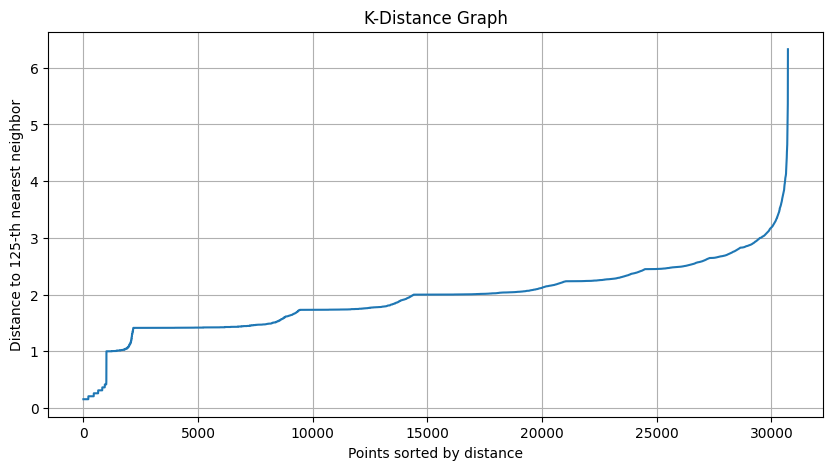

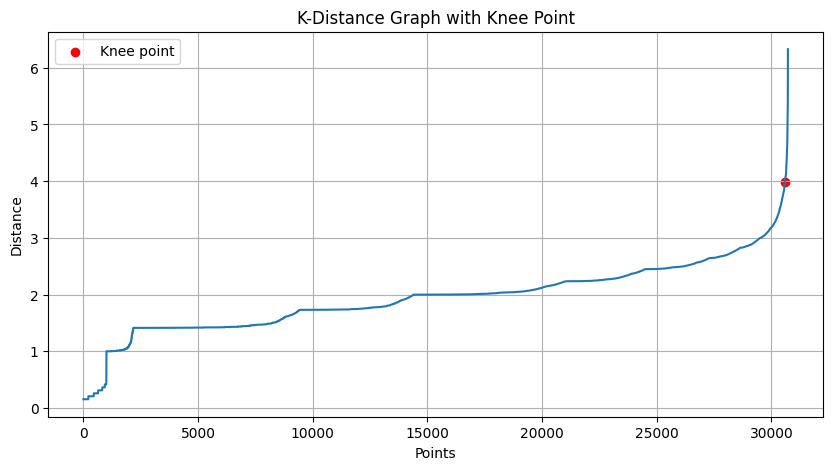

eps: 3.9809989675047057, min_pts: 1, clusters: 5
Eps: 3.981, MinPts: 1, Score: 578.352
eps: 3.9809989675047057, min_pts: 3, clusters: 3
Eps: 3.981, MinPts: 3, Score: 769.827
eps: 3.9809989675047057, min_pts: 5, clusters: 3
Eps: 3.981, MinPts: 5, Score: 769.827
eps: 3.9809989675047057, min_pts: 7, clusters: 3
Eps: 3.981, MinPts: 7, Score: 769.827
eps: 4.180048915879941, min_pts: 1, clusters: 4
Eps: 4.180, MinPts: 1, Score: 770.566
eps: 4.180048915879941, min_pts: 3, clusters: 3
Eps: 4.180, MinPts: 3, Score: 770.566
eps: 4.180048915879941, min_pts: 5, clusters: 3
Eps: 4.180, MinPts: 5, Score: 770.566
eps: 4.180048915879941, min_pts: 7, clusters: 3
Eps: 4.180, MinPts: 7, Score: 770.566
eps: 4.379098864255176, min_pts: 1, clusters: 4
Eps: 4.379, MinPts: 1, Score: 770.566
eps: 4.379098864255176, min_pts: 3, clusters: 3
Eps: 4.379, MinPts: 3, Score: 770.566
eps: 4.379098864255176, min_pts: 5, clusters: 3
Eps: 4.379, MinPts: 5, Score: 770.566
eps: 4.379098864255176, min_pts: 7, clusters: 3
Ep

In [12]:
#reduced_adult = feature_selection_cv(adult_df, 'income')
adult, y = preprocess(adult_df, 'income')

best_params = automated_dbscan(adult)
print("Best Parameters:", best_params)

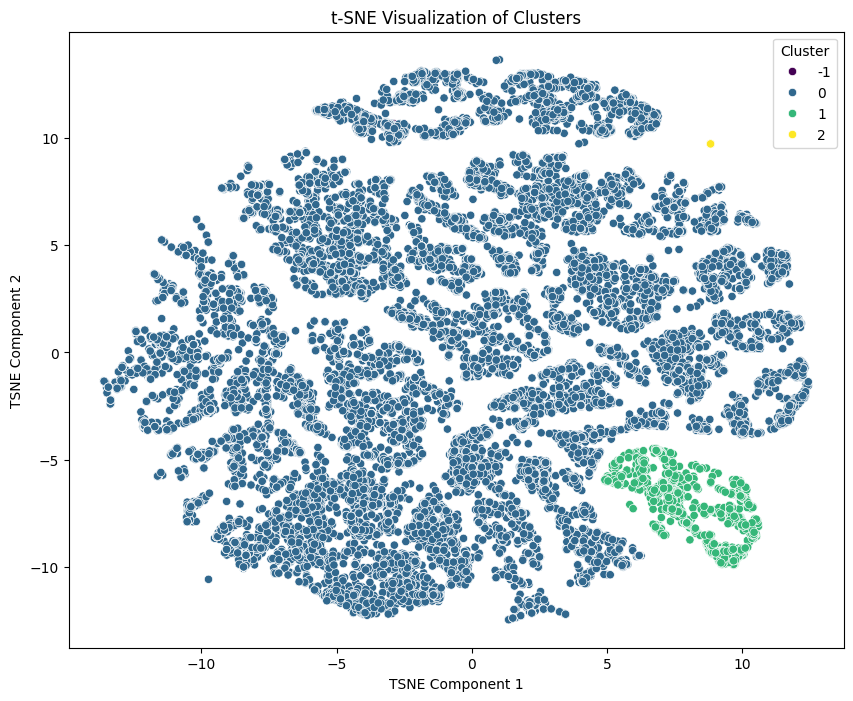

In [13]:
adult_labels = dbscan_clustering(adult, best_params['epsilon'],  4)
visualize_clusters(adult, adult_labels)

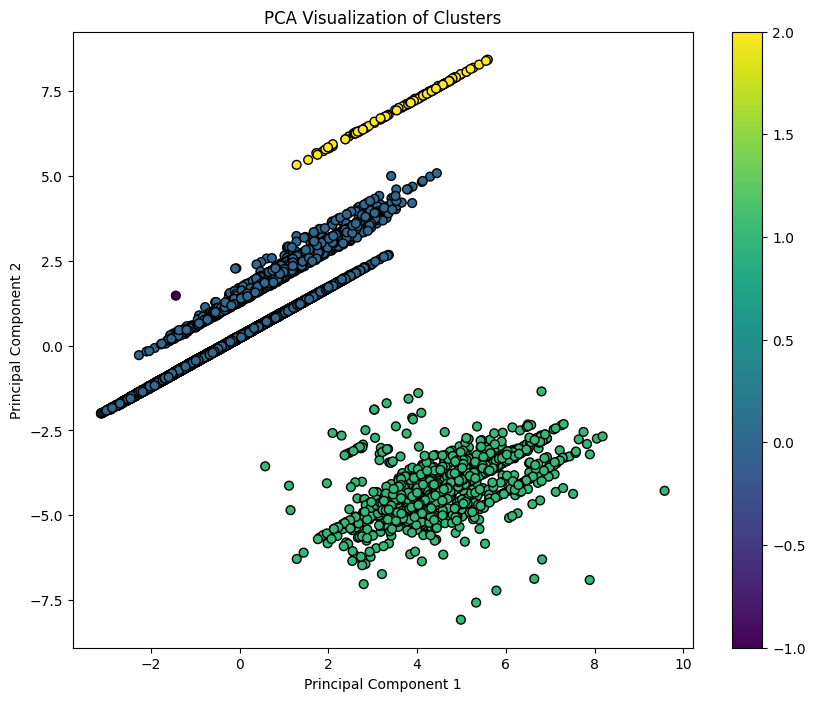

In [14]:
visualize_clusters_pca(adult, adult_labels)

In [15]:
adult['Cluster'] = adult_labels

# Contraceptive Method

In [16]:
file_path = 'cmc.data'
columns = [
    'wife_age', 'wife_edu', 'husband_edu', 'num_children', 'wife_religion', 'wife_working', 'husband_occupation',
    'standard_of_living_index', 'media_exposure', 'contraceptive_method'
]
cmc_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)


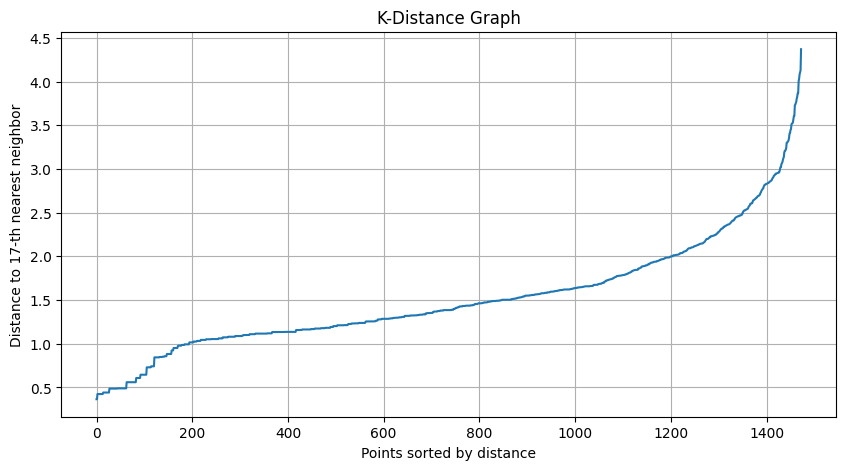

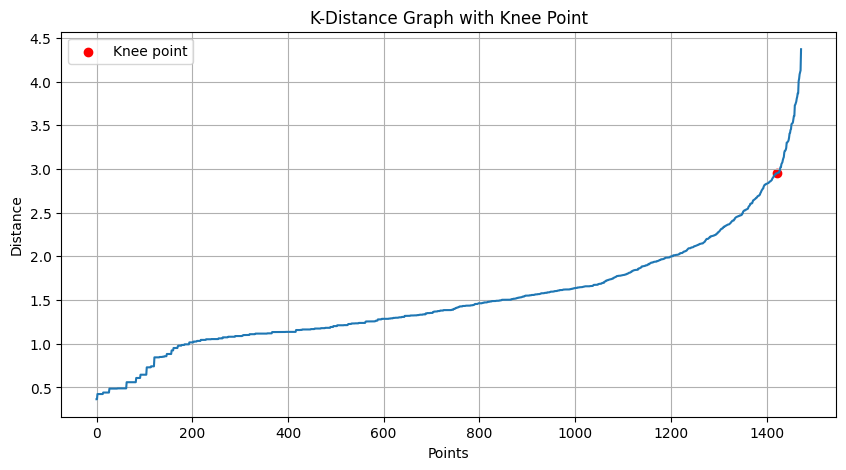

eps: 2.9484686439595236, min_pts: 1, clusters: 5
Eps: 2.948, MinPts: 1, Score: 12.907
eps: 2.9484686439595236, min_pts: 3, clusters: 2
Eps: 2.948, MinPts: 3, Score: 25.225
eps: 2.9484686439595236, min_pts: 5, clusters: 3
Eps: 2.948, MinPts: 5, Score: 17.568
eps: 2.9484686439595236, min_pts: 7, clusters: 2
Eps: 2.948, MinPts: 7, Score: 26.240
eps: 3.0958920761575, min_pts: 1, clusters: 3
Eps: 3.096, MinPts: 1, Score: 25.291
eps: 3.0958920761575, min_pts: 3, clusters: 2
Eps: 3.096, MinPts: 3, Score: 25.291
eps: 3.0958920761575, min_pts: 5, clusters: 2
Eps: 3.096, MinPts: 5, Score: 25.471
eps: 3.0958920761575, min_pts: 7, clusters: 2
Eps: 3.096, MinPts: 7, Score: 26.200
eps: 3.243315508355476, min_pts: 1, clusters: 3
Eps: 3.243, MinPts: 1, Score: 25.291
eps: 3.243315508355476, min_pts: 3, clusters: 2
Eps: 3.243, MinPts: 3, Score: 25.291
eps: 3.243315508355476, min_pts: 5, clusters: 2
Eps: 3.243, MinPts: 5, Score: 25.291
eps: 3.243315508355476, min_pts: 7, clusters: 2
Eps: 3.243, MinPts: 7

In [17]:
# Example usage
cmc, y = preprocess(cmc_df, 'contraceptive_method')
best_params = automated_dbscan(cmc)
print("Best DBSCAN Parameters:", best_params)


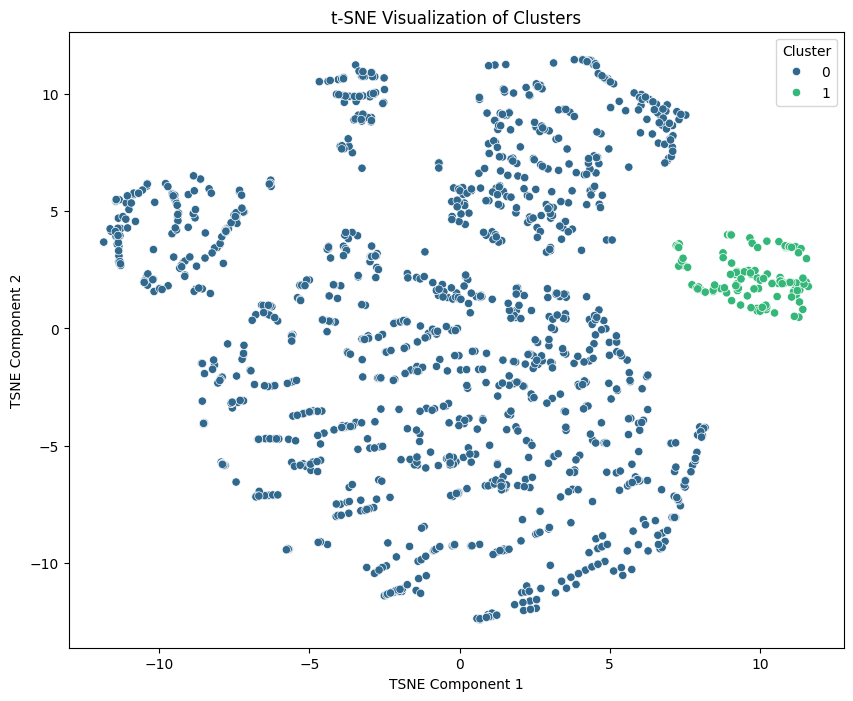

In [18]:
cmc_labels = dbscan_clustering(cmc,   3.390738940553452,  1)
visualize_clusters(cmc, cmc_labels)

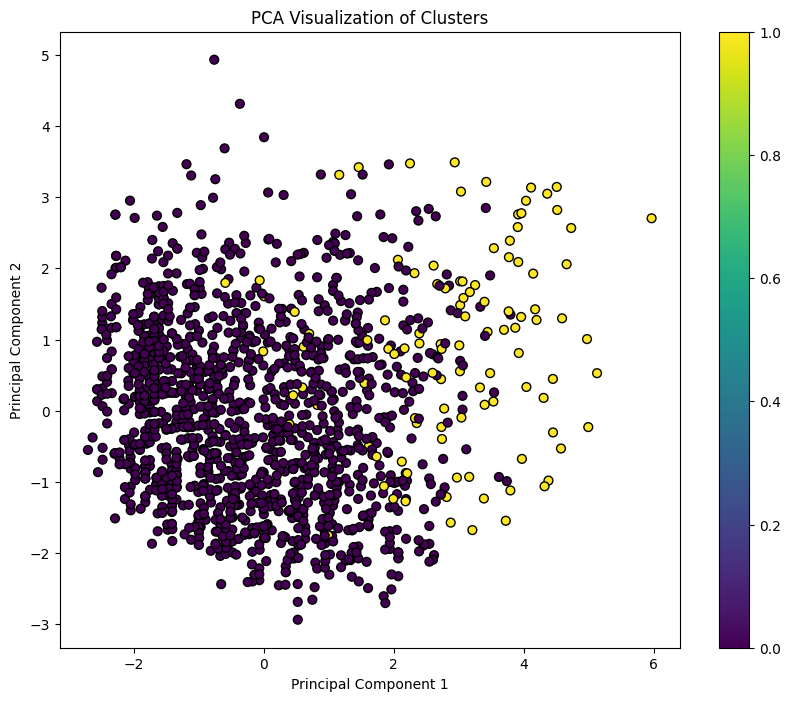

In [19]:
visualize_clusters_pca(cmc, cmc_labels)

# Student

Selected features: Index(['Course', 'Previous qualification (grade)', 'Father's occupation',
       'Admission grade', 'Tuition fees up to date', 'Age at enrollment',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)'],
      dtype='object')
Average score: 0.761071912467725


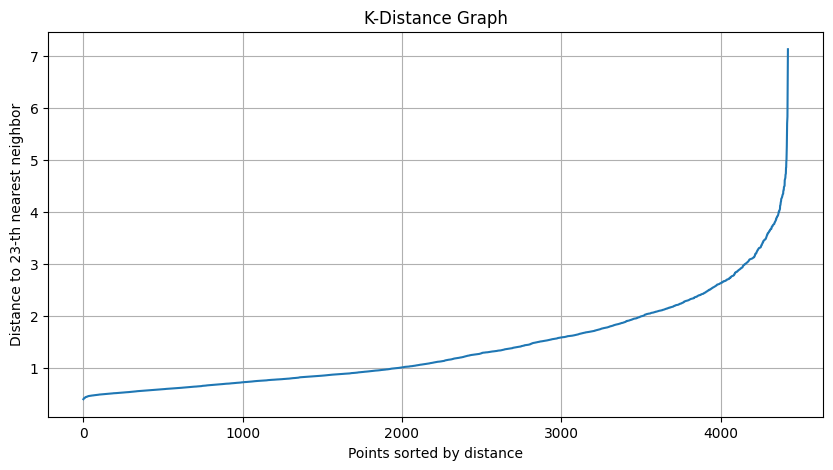

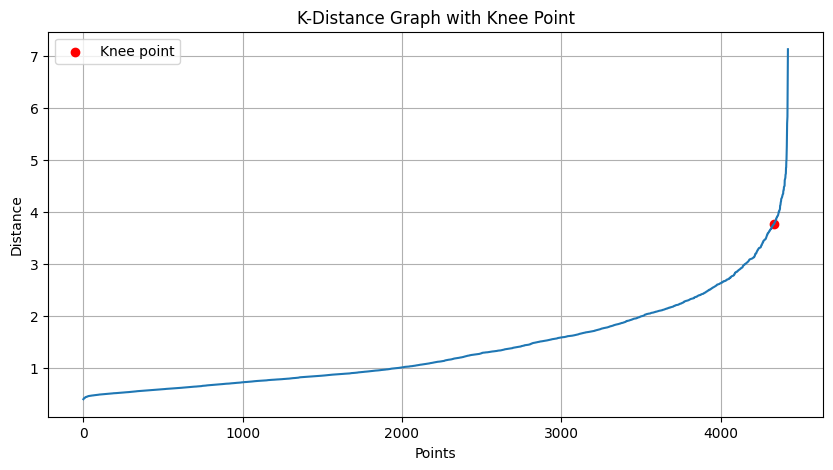

eps: 3.762310501151013, min_pts: 1, clusters: 8
Eps: 3.762, MinPts: 1, Score: 20.086
eps: 3.762310501151013, min_pts: 3, clusters: 2
Eps: 3.762, MinPts: 3, Score: 65.750
eps: 3.762310501151013, min_pts: 5, clusters: 3
Eps: 3.762, MinPts: 5, Score: 61.299
eps: 3.762310501151013, min_pts: 7, clusters: 3
Eps: 3.762, MinPts: 7, Score: 61.299
eps: 3.9504260262085635, min_pts: 1, clusters: 4
Eps: 3.950, MinPts: 1, Score: 1.192
eps: 3.9504260262085635, min_pts: 3, clusters: 1
eps: 3.9504260262085635, min_pts: 5, clusters: 1
eps: 3.9504260262085635, min_pts: 7, clusters: 1
eps: 4.138541551266115, min_pts: 1, clusters: 4
Eps: 4.139, MinPts: 1, Score: 1.192
eps: 4.138541551266115, min_pts: 3, clusters: 1
eps: 4.138541551266115, min_pts: 5, clusters: 1
eps: 4.138541551266115, min_pts: 7, clusters: 1
eps: 4.326657076323665, min_pts: 1, clusters: 4
Eps: 4.327, MinPts: 1, Score: 1.192
eps: 4.326657076323665, min_pts: 3, clusters: 1
eps: 4.326657076323665, min_pts: 5, clusters: 1
eps: 4.3266570763236

In [20]:
student_df = pd.read_csv('student_data.csv', delimiter=';')
reduced_student = feature_selection_cv(student_df, 'Target')
student = preprocess(reduced_student)

best_params = automated_dbscan(student)
print("Best Parameters:", best_params)

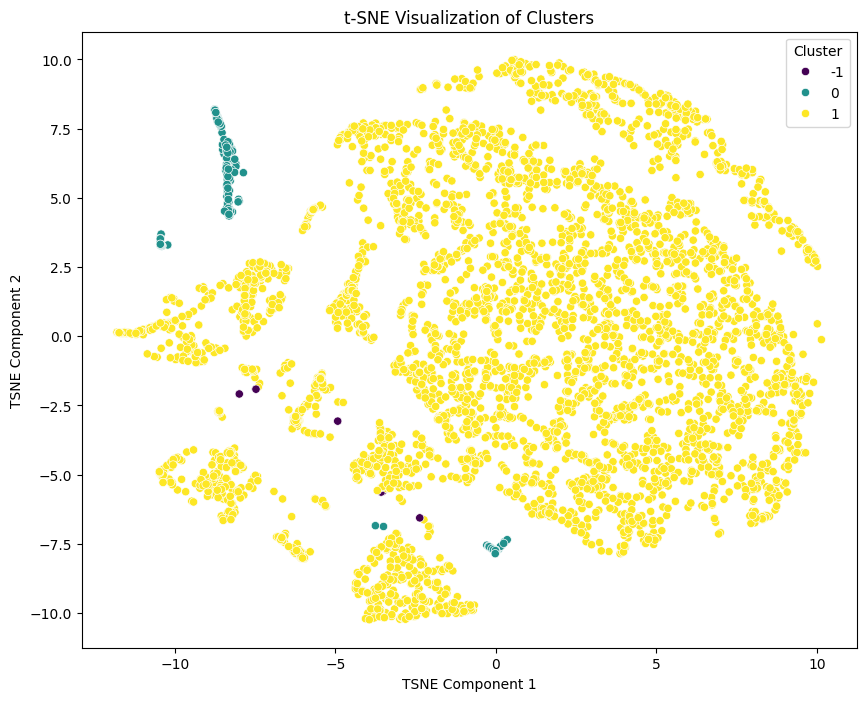

In [21]:
student_labels = dbscan_clustering(student, 3.762310501151013,  3)
visualize_clusters(student, student_labels)

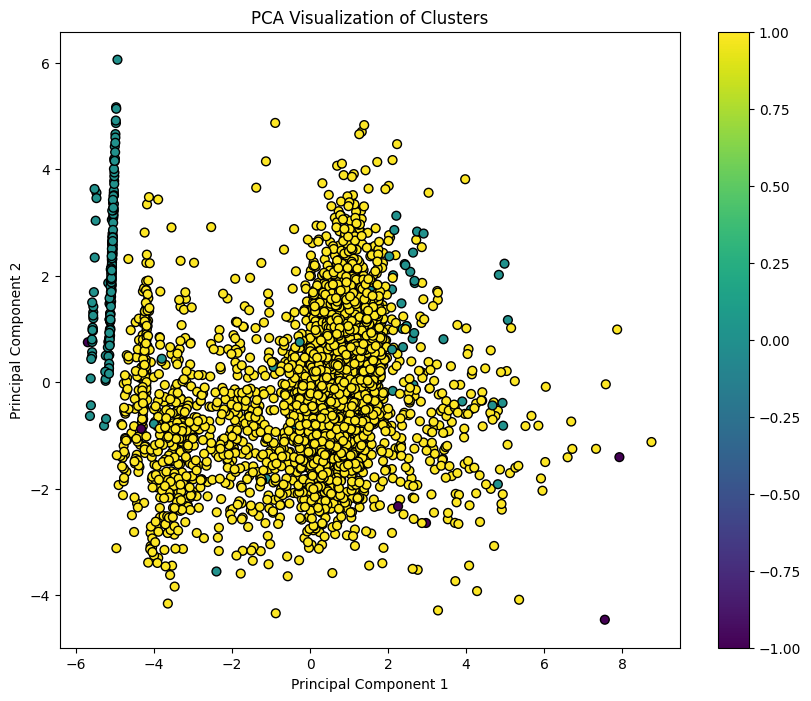

In [22]:
visualize_clusters_pca(student, student_labels)

# Cluster Analysis

In [23]:
# Compute descriptive statistics for each cluster
cluster_description = adult.groupby('Cluster').describe()

# Optionally, save the cluster description to a CSV for detailed analysis
cluster_description.to_csv("cluster_summary_stats.csv")


In [24]:
# For numerical features
cluster_means = adult.groupby('Cluster').mean()
cluster_medians = adult.groupby('Cluster').median()

# For categorical features, calculate the mode
cluster_modes = adult.select_dtypes(include=['object', 'category']).mode()


In [25]:
cluster_modes

""


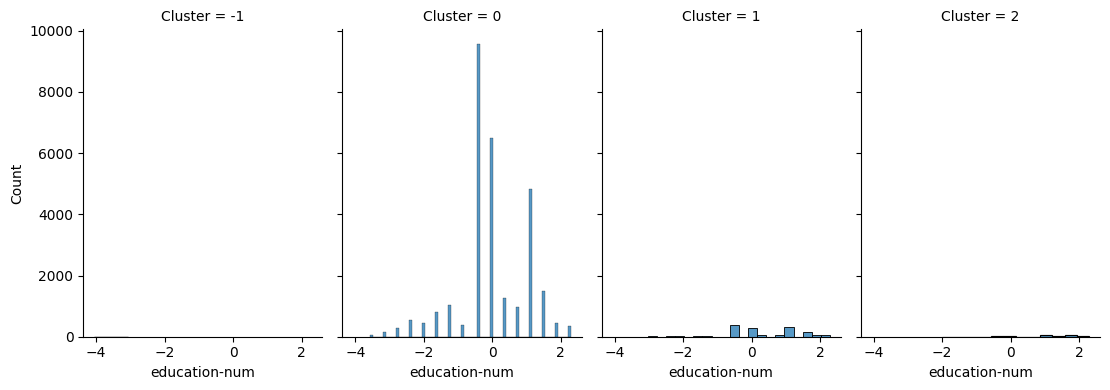

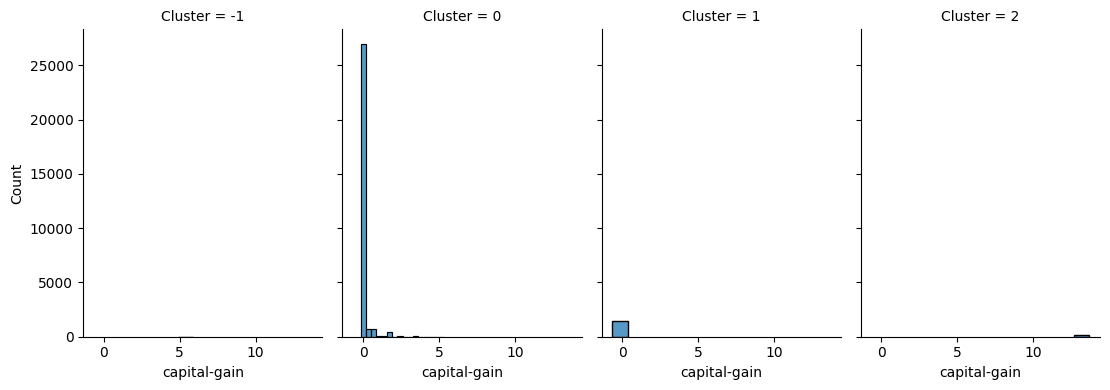

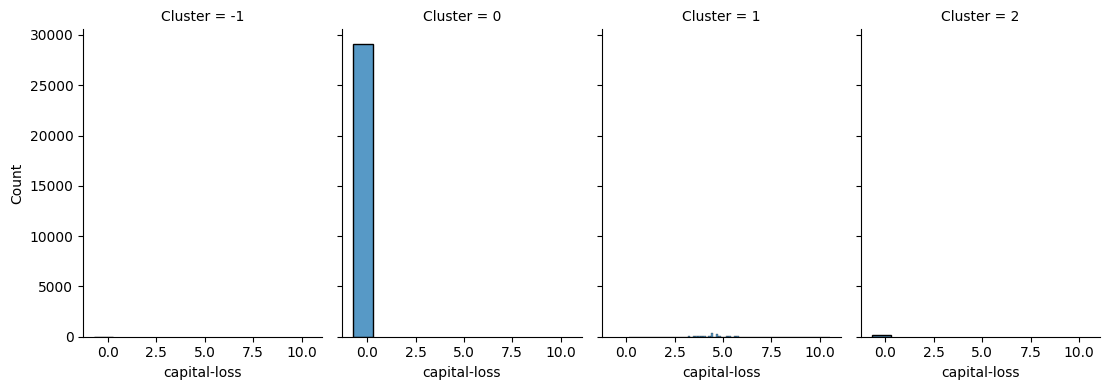

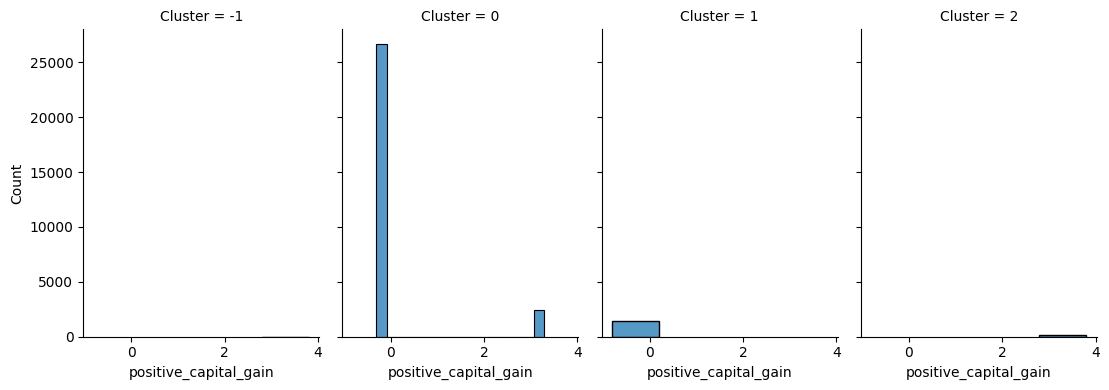

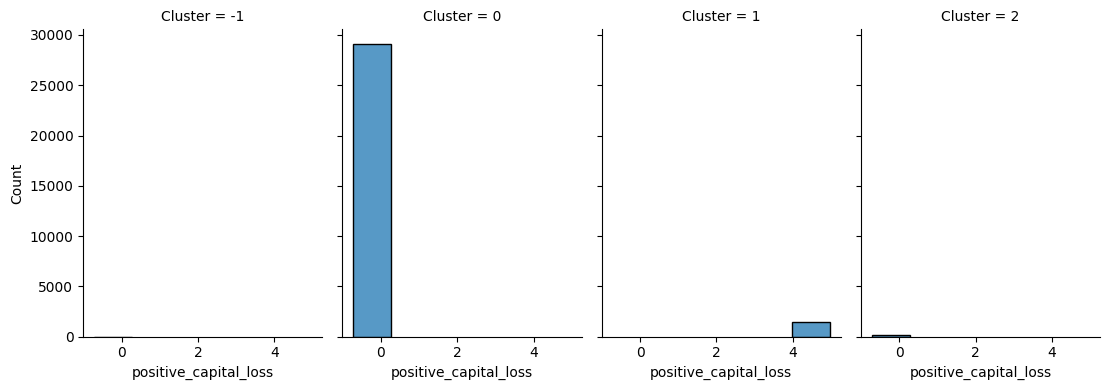

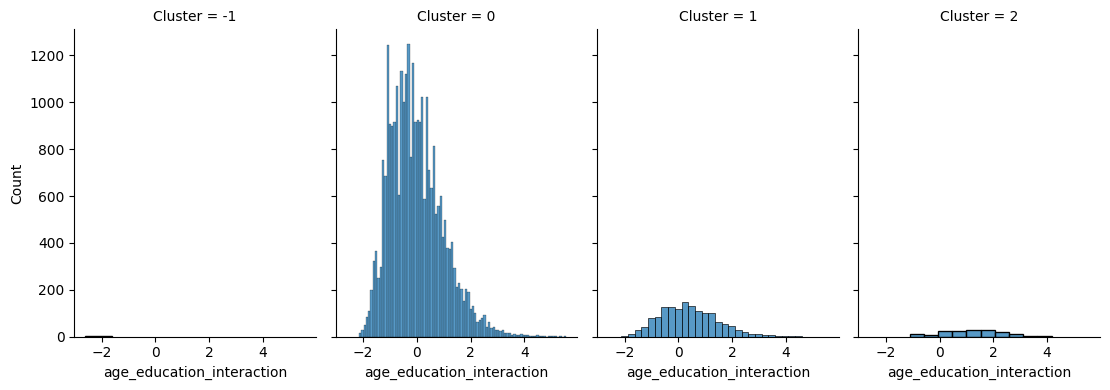

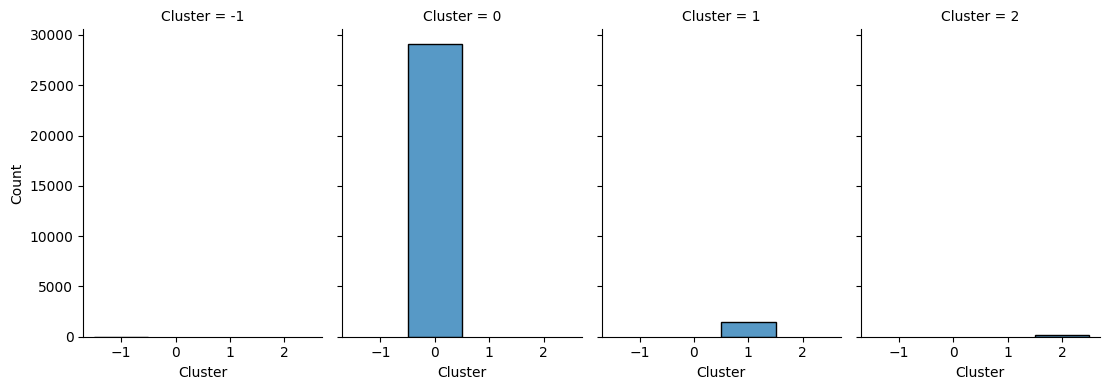

In [26]:
import seaborn as sns

# Numerical feature visualization
for col in adult.select_dtypes(include=np.number).columns:
    g = sns.FacetGrid(adult, col="Cluster", height=4, aspect=.7)
    g.map(sns.histplot, col)

# Categorical feature visualization
for col in adult.select_dtypes(include=['object', 'category']).columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Cluster', data=adult)
    plt.title(f'{col} distribution by Cluster')
    plt.xticks(rotation=45)
    plt.tight_layout()


In [27]:
from scipy import stats

# For numerical features
for col in adult.select_dtypes(include=np.number).columns:
    F, p = stats.f_oneway(*(adult[adult['Cluster'] == cluster][col] for cluster in adult['Cluster'].unique()))
    print(f"{col} - ANOVA test: F={F}, p={p}")


education-num - ANOVA test: F=130.84118055756812, p=3.175108472746065e-84
capital-gain - ANOVA test: F=77704.84754593606, p=0.0
capital-loss - ANOVA test: F=259301.39066712628, p=0.0
positive_capital_gain - ANOVA test: F=648.5272424685055, p=0.0
positive_capital_loss - ANOVA test: F=inf, p=0.0
age_education_interaction - ANOVA test: F=170.18034529180318, p=2.003408779098476e-109
Cluster - ANOVA test: F=inf, p=0.0


/var/folders/j0/85cyxkys2bs8n9q_b_twkb700000gn/T/ipykernel_49379/2908076578.py:5: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  F, p = stats.f_oneway(*(adult[adult['Cluster'] == cluster][col] for cluster in adult['Cluster'].unique()))
